Kontras (Contrast):
- Nilai Tinggi: Citra dengan banyak perbedaan intensitas yang tajam, seperti citra dengan tepi yang jelas atau pola dengan perubahan warna yang kontras (misalnya, gambar zebra atau teks dengan latar belakang putih).
- Nilai Rendah: Citra dengan perubahan intensitas yang halus atau sedikit variasi warna (misalnya, gambar langit biru cerah atau dinding dengan warna solid).

Dissimilarity:
- Nilai Tinggi: Citra dengan banyak variasi dalam intensitas piksel yang berdekatan, mirip dengan kontras tinggi (misalnya, gambar dengan banyak pola acak atau tepi tajam).
- Nilai Rendah: Citra yang lebih homogen dengan perubahan intensitas yang kecil (misalnya, permukaan yang halus dan seragam).

Homogenitas (Homogeneity):
- Nilai Tinggi: Citra yang sangat seragam dengan sedikit variasi dalam intensitas (misalnya, tekstur halus seperti kain katun polos atau area besar dengan warna solid).
- Nilai Rendah: Citra dengan banyak variasi dalam intensitas piksel (misalnya, gambar dengan banyak tekstur kompleks seperti daun pohon atau kulit kayu).

Entropi (Entropy):
- Nilai Tinggi: Citra yang sangat acak atau kompleks dengan distribusi intensitas yang tidak teratur (misalnya, citra dengan banyak noise atau pola acak).
- Nilai Rendah: Citra yang lebih teratur dan terstruktur (misalnya, area dengan warna solid atau pola berulang yang konsisten).

Energi (Energy):
- Nilai Tinggi: Citra dengan pola yang sangat teratur dan berulang, menunjukkan konsistensi yang tinggi dalam distribusi intensitas (misalnya, pola geometris yang berulang atau tekstur kain berulang).
- Nilai Rendah: Citra yang lebih acak dan kurang terstruktur (misalnya, gambar dengan banyak noise atau tekstur acak).

ASM (Angular Second Moment):
- Nilai Tinggi: Sama dengan energi, nilai tinggi menunjukkan tekstur yang seragam dan konsisten (misalnya, pola berulang yang jelas).
- Nilai Rendah: Sama dengan energi, nilai rendah menunjukkan tekstur yang lebih acak (misalnya, gambar dengan banyak variasi intensitas atau noise).

Korelasi (Correlation):
- Nilai Tinggi: Citra di mana nilai intensitas piksel memiliki hubungan linier yang kuat (misalnya, gradien halus atau pola dengan transisi warna yang konsisten).
- Nilai Rendah: Citra dengan variasi intensitas yang lebih acak dan kurang teratur (misalnya, gambar dengan banyak noise atau variasi acak dalam intensitas).

In [2]:
# Import library yang kalian butuhkan
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns


# Data Loading

In [3]:
# data = []
# labels = []
# file_name = []
# for sub_folder in os.listdir("dataset/"):
#     sub_folder_files = os.listdir(os.path.join("dataset/", sub_folder))
#     for i, filename in enumerate(sub_folder_files):
#         img_path = os.path.join("dataset/", sub_folder, filename)
        
#         img = cv.imread(img_path)
#         img = img.astype(np.uint8)
#         img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
#         data.append(img)
#         labels.append(sub_folder)
#         file_name.append(filename)
        
#         name = os.path.splitext(filename)[0]
#         if i == 49:
#             break
        

In [4]:
# len(data), len(labels), len(file_name)

# Data Augmentation & Data Loading

In [5]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset/"):
    sub_folder_files = os.listdir(os.path.join("dataset/", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset/", sub_folder, filename)
        
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        data.append(img)
        labels.append(sub_folder)
        file_name.append(filename)
        
        if i < 25:
            data.append(cv.rotate(img, cv.ROTATE_90_CLOCKWISE))
            labels.append(sub_folder)
            file_name.append(filename)
            
            data.append(cv.rotate(img, cv.ROTATE_90_COUNTERCLOCKWISE))
            labels.append(sub_folder)
            file_name.append(filename)
        
        name = os.path.splitext(filename)[0]
        if i == 49:
            break

In [6]:
len(data), len(labels), len(file_name)

(4200, 4200, 4200)

## Data Preparation

### Data Preprocessing

In [7]:
def tresholding(img, treshold):
    img[img < treshold] = 0
    img[img >= treshold] = 255
    return img

def normalize(img):
	img = img.astype(np.float32)
	img = (img - img.min()) / (img.max() - img.min())
	img = (img * 255).astype(np.uint8)
	return img

In [8]:
from skimage.filters import prewitt
dataPreprocessed = []
for i in range(len(data)):
    tes = data[i]
    tes = cv.resize(tes, (128, 128))
    tes = cv.medianBlur(tes, 9)
    tes = prewitt(tes)
    tes = normalize(tes)
    tes = tresholding(tes, 80)
    dataPreprocessed.append(tes)

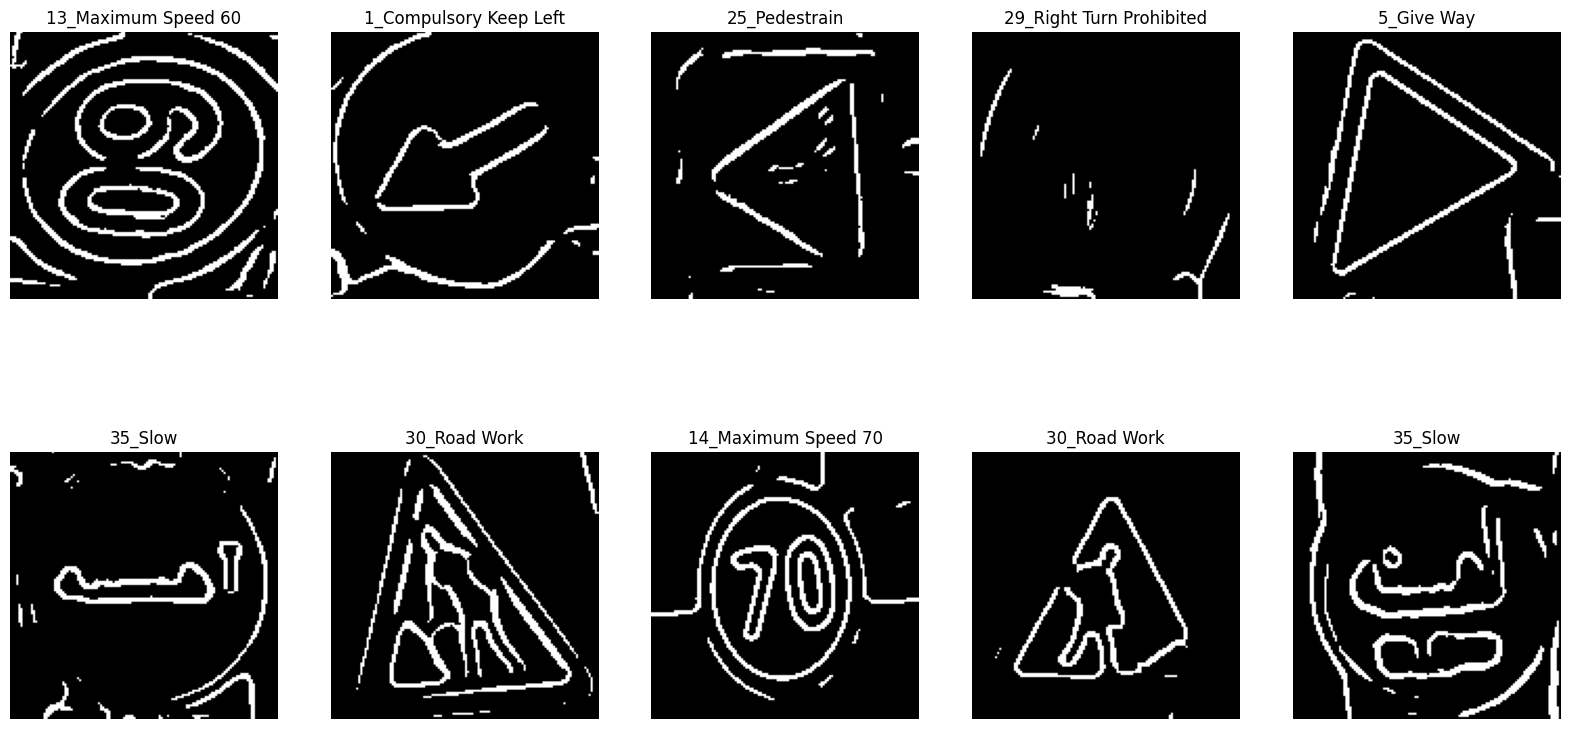

In [45]:
import random as rand

# show 10 random image
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i in range(2):
	for j in range(5):
		rand_index = rand.randint(0, len(dataPreprocessed))
		ax[i, j].imshow(dataPreprocessed[rand_index], cmap='gray')
		ax[i, j].set_title(labels[rand_index])
		ax[i, j].axis('off')
plt.show()

### Feature Extraction GLCM

In [10]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [11]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [12]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [13]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [14]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [15]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [16]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [17]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [18]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(data)):
    D0 = glcm(data[i], 0)
    D45 = glcm(data[i], 45)
    D90 = glcm(data[i], 90)
    D135 = glcm(data[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [19]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [20]:
for i in range(len(data)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [21]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [22]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [23]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [24]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [25]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [26]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [27]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasilEkstraksi.csv', index=False)

hasilEkstrak = pd.read_csv('hasilEkstraksi.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,00_00015.jpg,0_Compulsory Keep BothSide,61.042548,100.192202,64.335273,106.810330,0.215438,0.174005,0.209217,0.172775,...,0.001125,0.000976,0.033966,0.031502,0.033536,0.031248,0.983165,0.972200,0.982141,0.970364
1,00_00015.jpg,0_Compulsory Keep BothSide,64.335273,106.810330,61.042548,100.192202,0.209217,0.172775,0.215438,0.174005,...,0.001154,0.000992,0.033536,0.031248,0.033966,0.031502,0.982141,0.970364,0.983165,0.972200
2,00_00015.jpg,0_Compulsory Keep BothSide,64.335273,106.810330,61.042548,100.192202,0.209217,0.172775,0.215438,0.174005,...,0.001154,0.000992,0.033536,0.031248,0.033966,0.031502,0.982141,0.970364,0.983165,0.972200
3,00_00016.jpg,0_Compulsory Keep BothSide,165.910049,305.332219,152.095734,265.903160,0.171150,0.137422,0.173473,0.137357,...,0.000798,0.000648,0.027440,0.025505,0.028242,0.025450,0.924537,0.861410,0.930802,0.879307
4,00_00016.jpg,0_Compulsory Keep BothSide,152.095734,265.903160,165.910049,305.332219,0.173473,0.137357,0.171150,0.137422,...,0.000753,0.000650,0.028242,0.025450,0.027440,0.025505,0.930802,0.879307,0.924537,0.861410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,09_00046.jpg,9_Left Turn Prohibited,13.632104,17.644768,8.674707,17.426515,0.393690,0.326205,0.393680,0.327587,...,0.001923,0.001519,0.043788,0.038945,0.043850,0.038974,0.982057,0.976709,0.988571,0.976997
4196,09_00047.jpg,9_Left Turn Prohibited,11.661967,15.581721,8.796059,16.194438,0.406361,0.335426,0.396831,0.333434,...,0.002280,0.001840,0.048712,0.042986,0.047754,0.042893,0.987257,0.982801,0.990314,0.982128
4197,09_00048.jpg,9_Left Turn Prohibited,10.341543,14.421683,7.597411,13.112544,0.414681,0.344807,0.409428,0.343918,...,0.002392,0.001906,0.049043,0.043651,0.048904,0.043661,0.983284,0.976630,0.987695,0.978752
4198,09_00049.jpg,9_Left Turn Prohibited,6.986173,11.325023,7.236526,10.075106,0.423727,0.346538,0.409155,0.349612,...,0.002577,0.002100,0.052027,0.045545,0.050760,0.045822,0.983318,0.972911,0.982720,0.975901


### Features Selection

<Axes: >

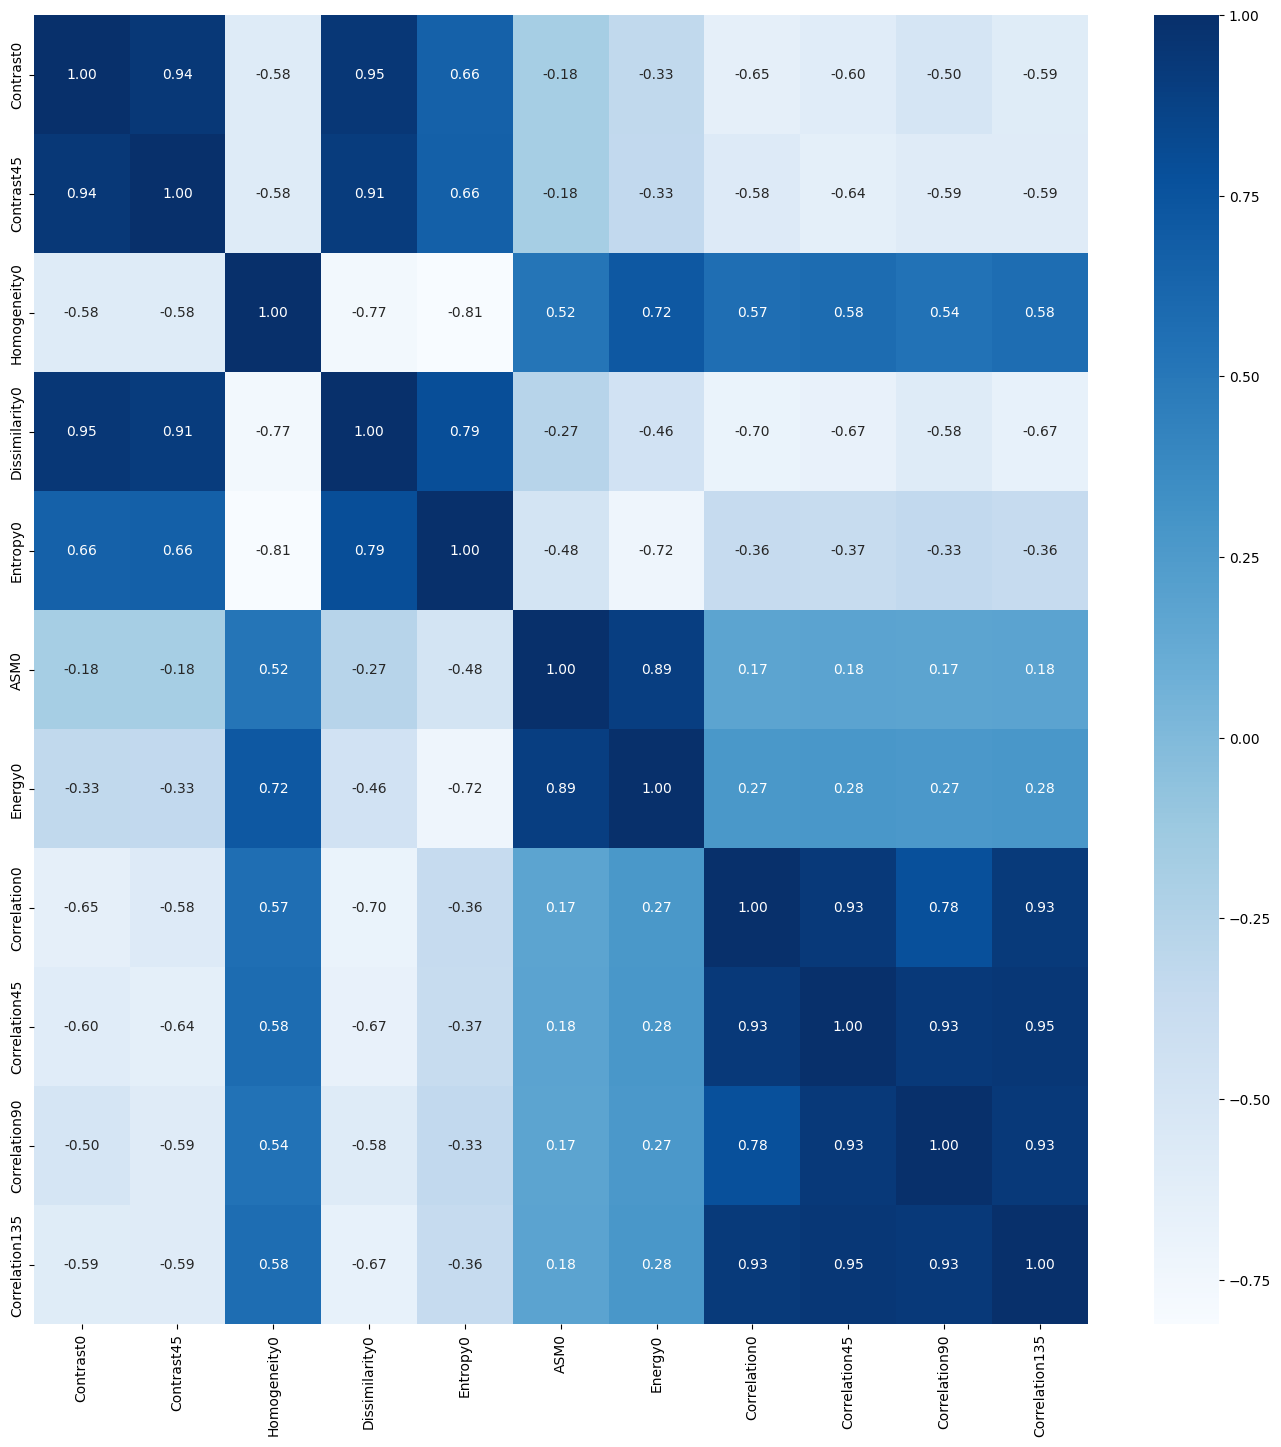

In [28]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

### Splitting Data

In [30]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train)
print(X_test)

       Contrast0  Contrast45  Homogeneity0  Dissimilarity0  Entropy0  \
2791   34.686794   56.552304      0.309251        3.738399  7.048124   
141    52.974155  106.045569      0.380121        3.469984  7.583174   
3635  331.537865  616.924455      0.309803        7.007633  7.102661   
491    22.836193   39.749679      0.672511        1.356296  6.022297   
198   204.620503  364.956046      0.219504        8.380947  8.417079   
...          ...         ...           ...             ...       ...   
3444  229.297449  484.732249      0.308360        8.097509  7.219211   
466    50.127087   94.195360      0.305192        4.183022  7.419390   
3092   41.281486   53.138979      0.341554        3.479849  7.786713   
3772  353.156843  693.570481      0.202575       10.098280  8.073769   
860    75.779664  141.008239      0.298649        4.627312  7.172929   

          ASM0   Energy0  Correlation0  Correlation45  Correlation90  \
2791  0.001699  0.041220      0.949311       0.917357       0.9

### Normalization

In [31]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

In [32]:
def crossValidation(x, y, model):
    y_pred = cross_val_predict(model, x, y, cv=20)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='macro', zero_division=1)
    recall = recall_score(y, y_pred, average='macro')
    f1 = f1_score(y, y_pred, average='macro')
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')
    return y_pred, accuracy, precision, recall, f1


print("KNN")
y_pred_knn, akurasiKNN, presisiKNN, recallKNN, f1KNN = crossValidation(x_new, y, KNeighborsClassifier(n_neighbors=20))

print("\nRandom Forest")
y_pred_rforest, akurasiRForest, presisiRForest, recallRForest, f1RForest = crossValidation(x_new, y, RandomForestClassifier(n_estimators=175, random_state=42))

print("\nSVM")
y_pred_svm, akurasiSVM, presisiSVM, recallSVM, f1SVM = crossValidation(x_new, y, SVC(kernel='rbf', random_state=42))

KNN
Accuracy: 7.71%
Precision: 7.04%
Recall: 7.71%
F1 Score: 7.13%

Random Forest
Accuracy: 47.60%
Precision: 46.83%
Recall: 47.60%
F1 Score: 46.88%

SVM
Accuracy: 7.38%
Precision: 64.57%
Recall: 7.38%
F1 Score: 3.30%
